# A simple example

To illustrate the application of quantile regression neural networks we consider a simple, 1-dimensional regression probelm with heteroscedastic uncertainty:

\begin{align}
y = \sin(x) + \cos(x) \cdot \mathcal{N}(0, 1)
\end{align}

The code below generates the synthetic training data consisting of $10^7$ randomly sampled $x$ values and corresponding $y$ values.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import quantnn.plotting
quantnn.plotting.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


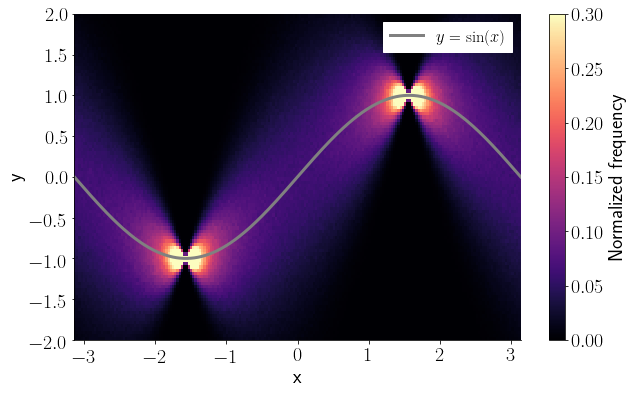

In [2]:
from quantnn.examples import simple
x, y = simple.create_training_data(10_000_000)
simple.plot_histogram(x, y)
plt.savefig("simple_training_data.png")

## Quantile regression neural networks (QRNNs)

The task of predicting the conditional distribution $P(y|x)$ of $y$ given input $x$ can be solved using quantile regression. The ``QRNN`` class of the quantnn package provides an implementation of a Quantile Regression Neural Network (QRNN), i.e. it uses a neural network to learn to predict the quantiles of the posterior distribution $P(y|x)$.


### Model definition and training

The simplest way to train a quantile regression neural network is to use the ``quantnn.QRNN`` class, which provides a simple interface to define and and train QRNNs based on fully-connected, feed-forward neural networks.

To do this all we need to do is to choose which quantiles to predict as well as the basic parameters of the network architecture. More specifically, the following information must be provided to the constructor of the ``QRNN`` class:

1. The list of quantiles that we want to predict.
2. The number of input features (``input_dimensions``). For this simple example this just ``1``.
3. A tuple describing the model architecture ``(n_layers, n_neurons, activation_function)``

> **Note:** quantnn will automatically choose the backend between Keras and PyTorch depending on which one is available on your system. You can specifically choose one over the other using the ``quantnn.qrnn.set_backend`` function.

In [3]:
import quantnn as q
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, input_dimensions=1, model=model)

Finally, we train the neural network on the training data. Here, we use only a subset of the data, in order to speed up the training process. We restart the training three times while lowering the learning rate, which leads to more accurate predicted quantiles.

In [4]:
training_data = (x[::10].reshape(-1, 1), y[::10].reshape(-1, 1))
qrnn.train(training_data=training_data,
           n_epochs=15)

/home/simon/src/quantnn/quantnn/models/pytorch/common.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float)
/home/simon/src/quantnn/quantnn/models/pytorch/common.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=dtype_y)


Epoch 0 / 15: Training error: 0.1642, Learning rate: 0.00100
Epoch 1 / 15: Training error: 0.1625, Learning rate: 0.00100
Epoch 2 / 15: Training error: 0.1622, Learning rate: 0.00100
Epoch 3 / 15: Training error: 0.1621, Learning rate: 0.00100
Epoch 4 / 15: Training error: 0.1620, Learning rate: 0.00100
Epoch 5 / 15: Training error: 0.1620, Learning rate: 0.00100
Epoch 6 / 15: Training error: 0.1619, Learning rate: 0.00100
Epoch 7 / 15: Training error: 0.1619, Learning rate: 0.00100
Epoch 8 / 15: Training error: 0.1619, Learning rate: 0.00100
Epoch 9 / 15: Training error: 0.1619, Learning rate: 0.00100
Epoch 10 / 15: Training error: 0.1618, Learning rate: 0.00100
Epoch 11 / 15: Training error: 0.1618, Learning rate: 0.00100
Epoch 12 / 15: Training error: 0.1618, Learning rate: 0.00100
Epoch 13 / 15: Training error: 0.1618, Learning rate: 0.00100
Epoch 14 / 15: Training error: 0.1618, Learning rate: 0.00100


{'training_errors': [0.1641994909756744,
  0.16247455282084342,
  0.16222329127577959,
  0.16208973579600844,
  0.16201034776153042,
  0.16196479052076326,
  0.16193219283438315,
  0.16190608257415412,
  0.16188234766049686,
  0.16185707872074442,
  0.16184224844116218,
  0.16182652589637564,
  0.1618176061131682,
  0.16180387542941177,
  0.1617875432684308],
 'validation_errors': []}

### Evaluation

To evaluate the QRNN we generate 1000 new $x$-value and use the ``predict`` method of the trained ``qrnn`` object to predict the quantiles of $y$.

In [6]:
n = 1_000
x_val = np.linspace(-np.pi, np.pi, n)
y_val = simple.create_validation_data(x_val)
y_pred = qrnn.predict(x_val.reshape(-1, 1))
y_mean = q.posterior_mean(y_pred, qrnn.quantiles)

We can now compare the quantiles predicted using the QRNN to the empirical quantiles from the training data. As can be seen from the plot below, the QRNN successfully predicts the quantiles of the posterior distribution.

[<matplotlib.lines.Line2D object at 0x7fdaec6d27f0>, <matplotlib.lines.Line2D object at 0x7fdaec6d2b20>]


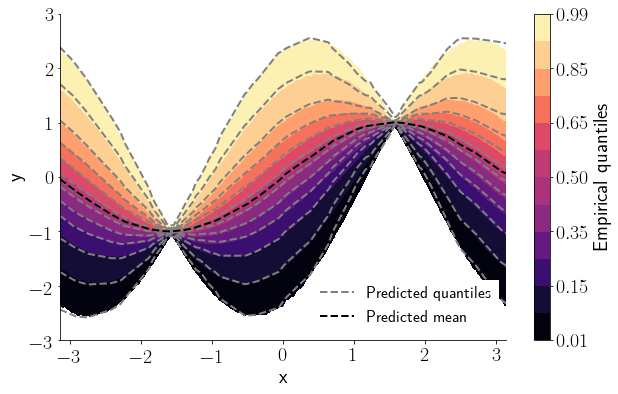

In [7]:
simple.plot_results(x, y, x_val, y_pred, y_mean, quantiles)
plt.savefig("simple_results.pdf")

## Density regression neural network

An alternative way to learn to predict the distribution $P(y|x)$ is to use a neural network to predict a gridded approximation of the probability density function, a technique we will, for simplicity, refer to as Density Regression Neural Network (DRNN).


In [8]:
from quantnn.drnn import DRNN
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
bins = np.linspace(-3, 3, 101)
drnn = DRNN(bins, input_dimensions=1, model=model)

In [9]:
training_data = (x[::10].reshape(-1, 1), y[::10].reshape(-1, 1))
drnn.train(training_data=training_data,
           n_epochs=10)

/home/simon/src/quantnn/quantnn/models/pytorch/common.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float)
/home/simon/src/quantnn/quantnn/models/pytorch/common.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=dtype_y)


Epoch 0 / 10: Training error: 3.6029, Learning rate: 0.00100
Epoch 1 / 10: Training error: 3.5693, Learning rate: 0.00100
Epoch 2 / 10: Training error: 3.5649, Learning rate: 0.00100
Epoch 3 / 10: Training error: 3.5627, Learning rate: 0.00100
Epoch 4 / 10: Training error: 3.5614, Learning rate: 0.00100
Epoch 5 / 10: Training error: 3.5606, Learning rate: 0.00100
Epoch 6 / 10: Training error: 3.5599, Learning rate: 0.00100
Epoch 7 / 10: Training error: 3.5596, Learning rate: 0.00100
Epoch 8 / 10: Training error: 3.5592, Learning rate: 0.00100
Epoch 9 / 10: Training error: 3.5589, Learning rate: 0.00100


{'training_errors': [3.6028759745042627,
  3.5693220600249274,
  3.5649095347033852,
  3.562659248228996,
  3.5614061477668946,
  3.56058058601981,
  3.5599499857859067,
  3.559568939914596,
  3.5591517659986684,
  3.5589456317123243],
 'validation_errors': []}

In [12]:
y_pred = drnn.predict(x_val.reshape(-1, 1))

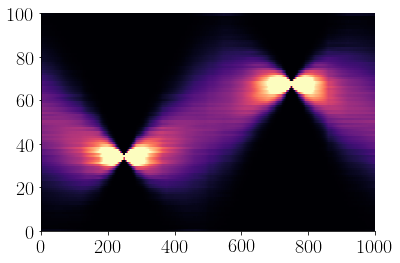

In [19]:
from matplotlib.colors import Normalize
x = 0.5 * (drnn.bins[1:] + drnn.bins[:-1])
plt.pcolormesh(y_pred.T, norm=Normalize(0.0, 1.0))

In [20]:
drnn.save("test.pt")

In [21]:
DRNN.load("test.pt")

RuntimeError: [enforce fail at inline_container.cc:145] . PytorchStreamReader failed reading zip archive: failed finding central directory

In [42]:
y_predkk

array([[0.00224436, 0.00047566, 0.00044021, ..., 0.00030421, 0.00035045,
        0.00216959],
       [0.00225467, 0.00047929, 0.00044385, ..., 0.00030606, 0.00035245,
        0.00217461],
       [0.00226502, 0.00048295, 0.00044752, ..., 0.00030793, 0.00035446,
        0.00217963],
       ...,
       [0.00096336, 0.00023879, 0.00019661, ..., 0.0005873 , 0.00043516,
        0.00253396],
       [0.00097036, 0.00023751, 0.0001974 , ..., 0.0005818 , 0.0004279 ,
        0.00251143],
       [0.00097741, 0.00023624, 0.00019819, ..., 0.00057636, 0.00042076,
        0.00248908]], dtype=float32)

In [36]:
from scipy.special import softmax

In [35]:
softmax?